<a href="https://colab.research.google.com/github/muhammadhafiz27/Deep-Learning/blob/main/Variational_Autoencoder_(VAE)_untuk_Pembangkitan_Citra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# **Load Dataset**

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 610kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.13MB/s]


# **Definisi Model VAE**

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        # Decoder
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# **Inisialisasi Model dan Optimizer**

In [4]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# **Fungsi Loss**

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# **Training Loop**

In [6]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    for data, _ in trainloader:
        data = data.view(-1, 784)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(trainloader.dataset):.4f}')

Epoch [1/10], Loss: 165.3635
Epoch [2/10], Loss: 121.6088
Epoch [3/10], Loss: 114.4558
Epoch [4/10], Loss: 111.4991
Epoch [5/10], Loss: 109.6896
Epoch [6/10], Loss: 108.5175
Epoch [7/10], Loss: 107.6505
Epoch [8/10], Loss: 106.9442
Epoch [9/10], Loss: 106.4771
Epoch [10/10], Loss: 106.0455


# **Visualisasi Hasil**

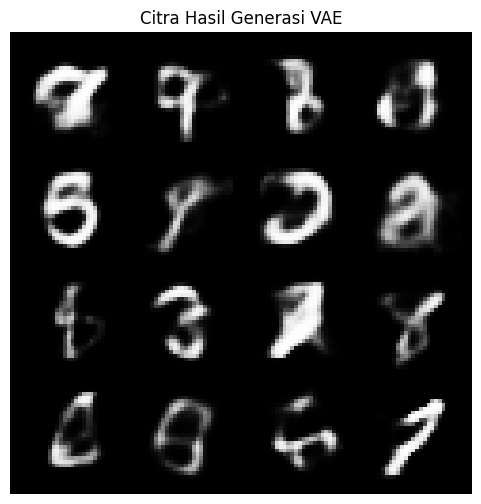

In [7]:
with torch.no_grad():
    z = torch.randn(16, 20)
    sample = model.decode(z).view(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(sample, nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Citra Hasil Generasi VAE")
    plt.axis('off')
    plt.show()